## EDA - Analysis of bounding boxes shape

From https://www.kaggle.com/aantonova/practical-eda-on-numerical-data

In [1]:
%matplotlib inline

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
import pydicom

In [3]:
import gc
import warnings
warnings.simplefilter(action = 'ignore')

In [4]:
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import roc_auc_score, mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold

### Loading data

In [5]:
detailed_class_info = pd.read_csv('../data/stage_1_detailed_class_info.csv')
# detailed_class_info presents the same lines as train_labels which means some of them are duplicated
detailed_class_info = detailed_class_info.drop_duplicates()
train_labels = pd.read_csv('../data/stage_1_train_labels.csv')

df = pd.merge(left = detailed_class_info, right = train_labels, how = 'left', on = 'patientId')

#del detailed_class_info, train_labels
#gc.collect()

df.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28989 entries, 0 to 28988
Data columns (total 7 columns):
patientId    28989 non-null object
class        28989 non-null object
x            8964 non-null float64
y            8964 non-null float64
width        8964 non-null float64
height       8964 non-null float64
Target       28989 non-null int64
dtypes: float64(4), int64(1), object(2)
memory usage: 1.8+ MB


### Number of images per class

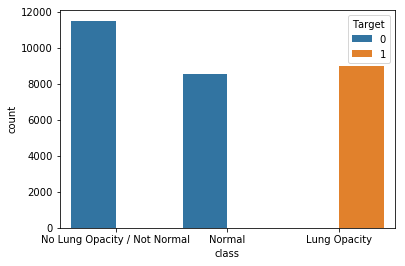

In [6]:
sns.countplot(x = 'class', hue = 'Target', data = df);

In [7]:
df[df['Target'] != 0]['patientId'].value_counts().value_counts()

2    3062
1    2481
3     105
4      11
Name: patientId, dtype: int64

### Bounding boxes distribution

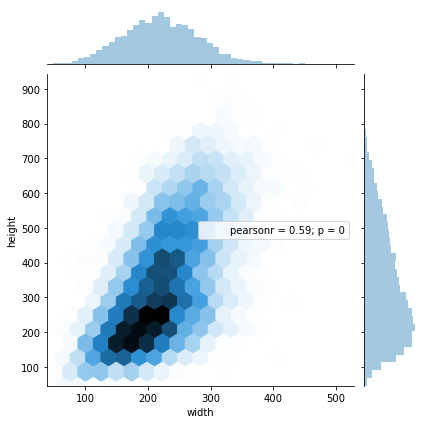

In [8]:
sns.jointplot(x = 'width', y = 'height', data = df, kind = 'hex', gridsize = 20);

In [9]:
X = df[['width', 'height']].dropna()

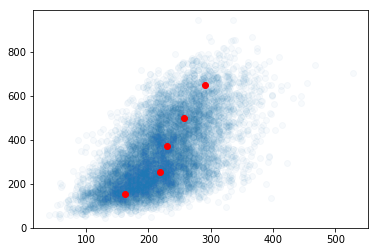

In [10]:
n_clusters = 5
k_means = KMeans(n_clusters=n_clusters).fit(X)

centers = k_means.cluster_centers_

x = X['width'].values
y = X['height'].values

plt.scatter(x, y, alpha = 0.03)
plt.scatter(centers[:,0], centers[:,1], color = 'red')

### Looking at the image

In [12]:
patientId = df['patientId'][0]
dcm_file = '../data/stage_1_train_images/%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)

print(dcm_data)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0020) Patient ID                          LO: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

In [13]:
im = dcm_data.pixel_array
print(type(im))
print(im.dtype)
print(im.shape)

<class 'numpy.ndarray'>
uint8
(1024, 1024)


(-0.5, 1023.5, 1023.5, -0.5)

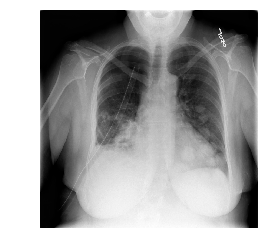

In [17]:
plt.imshow(im, cmap=pylab.cm.gist_gray)
plt.axis('off')

In [22]:
def draw(data):
    """
    Method to draw single patient with bounding box(es) if present 

    """
    # --- Open DICOM file
    d = pydicom.read_file(data['dicom'])
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # --- Add boxes with random color if present
    for box in data['boxes']:
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=6)

    pylab.imshow(im, cmap=pylab.cm.gist_gray)
    pylab.axis('off')

def overlay_box(im, box, rgb, stroke=1):
    """
    Method to overlay single box on image

    """
    # --- Convert coordinates to integers
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

In [23]:
draw(dcm_file)

TypeError: string indices must be integers